In [1]:
from dataclasses import dataclass
import tqdm
from typing import Callable, Dict, Optional, Tuple, Union

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import Tensor
from torch.distributions import Distribution as torchDist

from distributions import SamplableDistribution, GaussianMixture, Distribution
from samplers import sampler
from tools.benchmark import BenchmarkUtils, Benchmark

/tmp/ipykernel_6798/2656450616.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
seed = 123

torch.manual_seed(seed)

mass_points_count = 2
gaussian_count = 1
chain_count = 2
dimension = 2
distance_to_mass_points = 0.1
device = "cpu"


true_means = torch.rand((gaussian_count, mass_points_count)) * 2 - 1
true_covs = torch.eye(mass_points_count).repeat(gaussian_count, 1, 1)

sample_count = 1000
gm = GaussianMixture(true_means, true_covs,
                     torch.full((gaussian_count,), 1/mass_points_count, dtype=torch.float64))

starting_points = BenchmarkUtils.generate_starting_points(
    chain_count, dimension,
    true_means,
    distance_to_mass_points
)


params = sampler.Params(
    target_dist=gm,
    starting_point=starting_points,
    proposal_dist=torch.distributions.MultivariateNormal(
        torch.zeros(dimension, device=device),
        torch.eye(dimension, device=device),
    ),
    meta={
        "sigma": 1.,
        "rho": 0.015,
        "alpha": 0.574,
        "device": device,
    },
)
cache = sampler.Cache(
    params=params
)

In [3]:
@dataclass
class MALAIter(sampler.Iteration):
    def run(self):
        noise = self.cache.params.proposal_dist.sample(self.cache.point.shape[:-1])

        proposal_point = (
            self.cache.point + 
            0.5 * self.cache.grad * self.cache.params.meta["sigma"] ** 2 + 
            noise * self.cache.params.meta["sigma"]
        ).detach().requires_grad_()

        logp_y = self.cache.params.target_dist.log_prob(proposal_point)
        grad_y = torch.autograd.grad(
            logp_y.sum(),
            proposal_point,
        )[0].detach()

        with torch.no_grad():
            log_qyx = self.cache.params.proposal_dist.log_prob(noise)
            log_qxy = self.cache.params.proposal_dist.log_prob(
                (self.cache.point - proposal_point - 
                0.5 * self.cache.params.meta["sigma"] ** 2 * grad_y) / self.cache.params.meta["sigma"]
            )
            
            accept_prob = torch.clamp((logp_y + log_qxy - self.cache.logp - log_qyx).exp(), max=1).detach()
            mask = torch.rand_like(accept_prob) < accept_prob

            self.cache.point[mask] = proposal_point[mask]
            self.cache.logp[mask] = logp_y[mask]
            self.cache.grad[mask] = grad_y[mask]

            self.cache.params.meta["sigma"] *= (
                1 + self.cache.params.meta["rho"] * (
                    accept_prob[..., None] - self.cache.params.meta["alpha"]
                )
            ) ** 0.5

        self.cache.samples.append(self.cache.point.detach().clone())
        # self.cache.point = self.cache.point.requires_grad_()

In [4]:
mala_iter = MALAIter(cache)

In [5]:
mala_iter.init()

In [6]:
mala_iter.run()

In [7]:
mala_iter.cache.samples

[tensor([[-1.7633, -0.1508],
         [-0.4155,  0.0398]])]

In [8]:
mala_burn_in = sampler.SampleBlock(
    iteration=mala_iter,
    iteration_count=1000,
)
mala_sampler = sampler.SampleBlock(
    iteration=mala_iter,
    iteration_count=1000,
)

In [9]:
alg = sampler.Pipeline(
    [mala_burn_in, mala_sampler]
)

In [10]:
alg.run()

Cache(params=Params(target_dist=<distributions.GaussianMixture object at 0x75788416f0d0>, starting_point=tensor([[-1.6288,  0.1242],
        [ 0.3869, -0.7032]], requires_grad=True), proposal_dist=MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])), meta={'sigma': tensor([[1.5641],
        [1.5855]]), 'rho': 0.015, 'alpha': 0.574, 'device': 'cpu'}), samples=[tensor([[-1.7633, -0.1508],
        [-0.4155,  0.0398]]), tensor([[-0.8727, -0.4500],
        [-0.1769,  0.7012]]), tensor([[-2.0616,  0.6409],
        [-0.9247,  1.6023]]), tensor([[-2.0616,  0.6409],
        [-1.0544, -0.0809]]), tensor([[-2.0616,  0.6409],
        [-1.9505,  0.1072]]), tensor([[-1.7060, -0.1876],
        [-1.4798,  0.2769]]), tensor([[-1.6537, -0.1171],
        [-1.4798,  0.2769]]), tensor([[ 0.0835, -1.4428],
        [-0.5210, -1.0881]]), tensor([[ 0.5393, -1.0009],
        [-2.4386,  0.4753]]), tensor([[ 0.9451, -0.1876],
        [-0.6057,  0.5978]]), tensor([[ 0.4319, -0.3805],
   

In [11]:
res = alg.cache.samples[1000:]
res = torch.cat(res, 0)

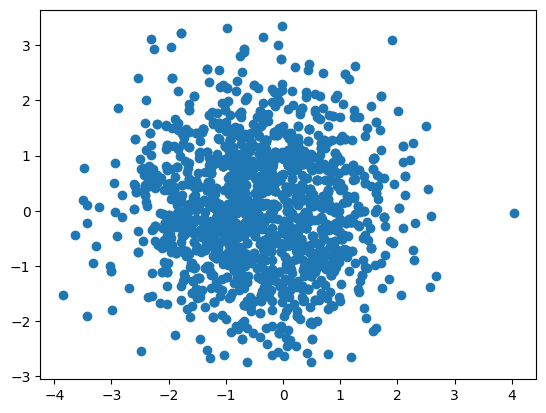

In [12]:
plt.scatter(res[:, 0], res[:, 1])

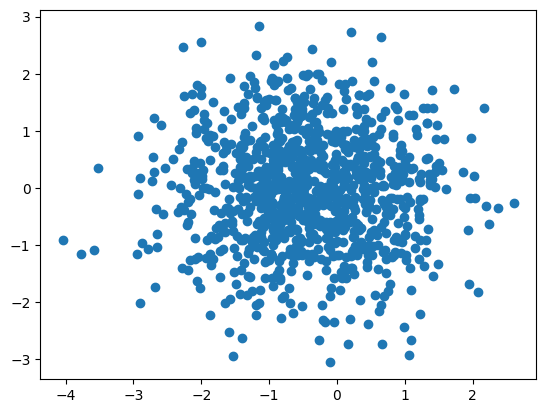

In [13]:
true_samples = gm.sample(sample_count)
plt.scatter(true_samples[:, 0], true_samples[:, 1])